Processing 0004_000...
Image 0 shape: (1024, 1024, 3)
Image 1 shape: (1024, 1024, 3)
Mask 0 shape: (1024, 1024), unique values: [  0 255]
Mask 1 shape: (1024, 1024), unique values: [  0 255]
Intrinsic 0:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]
Intrinsic 1:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]

Baseline distance: 0.788222 units

Rectifying stereo pair...
Rectification matrices computed
New projection matrix P0:
[[819.2          0.         283.67178345   0.        ]
 [  0.         819.2        534.78796387   0.        ]
 [  0.           0.           1.           0.        ]]
New projection matrix P1:
[[ 819.2           0.          740.41519165 -645.71162867]
 [   0.          819.2         534.78796387    0.        ]
 [   0.            0.            1.            0.        ]]


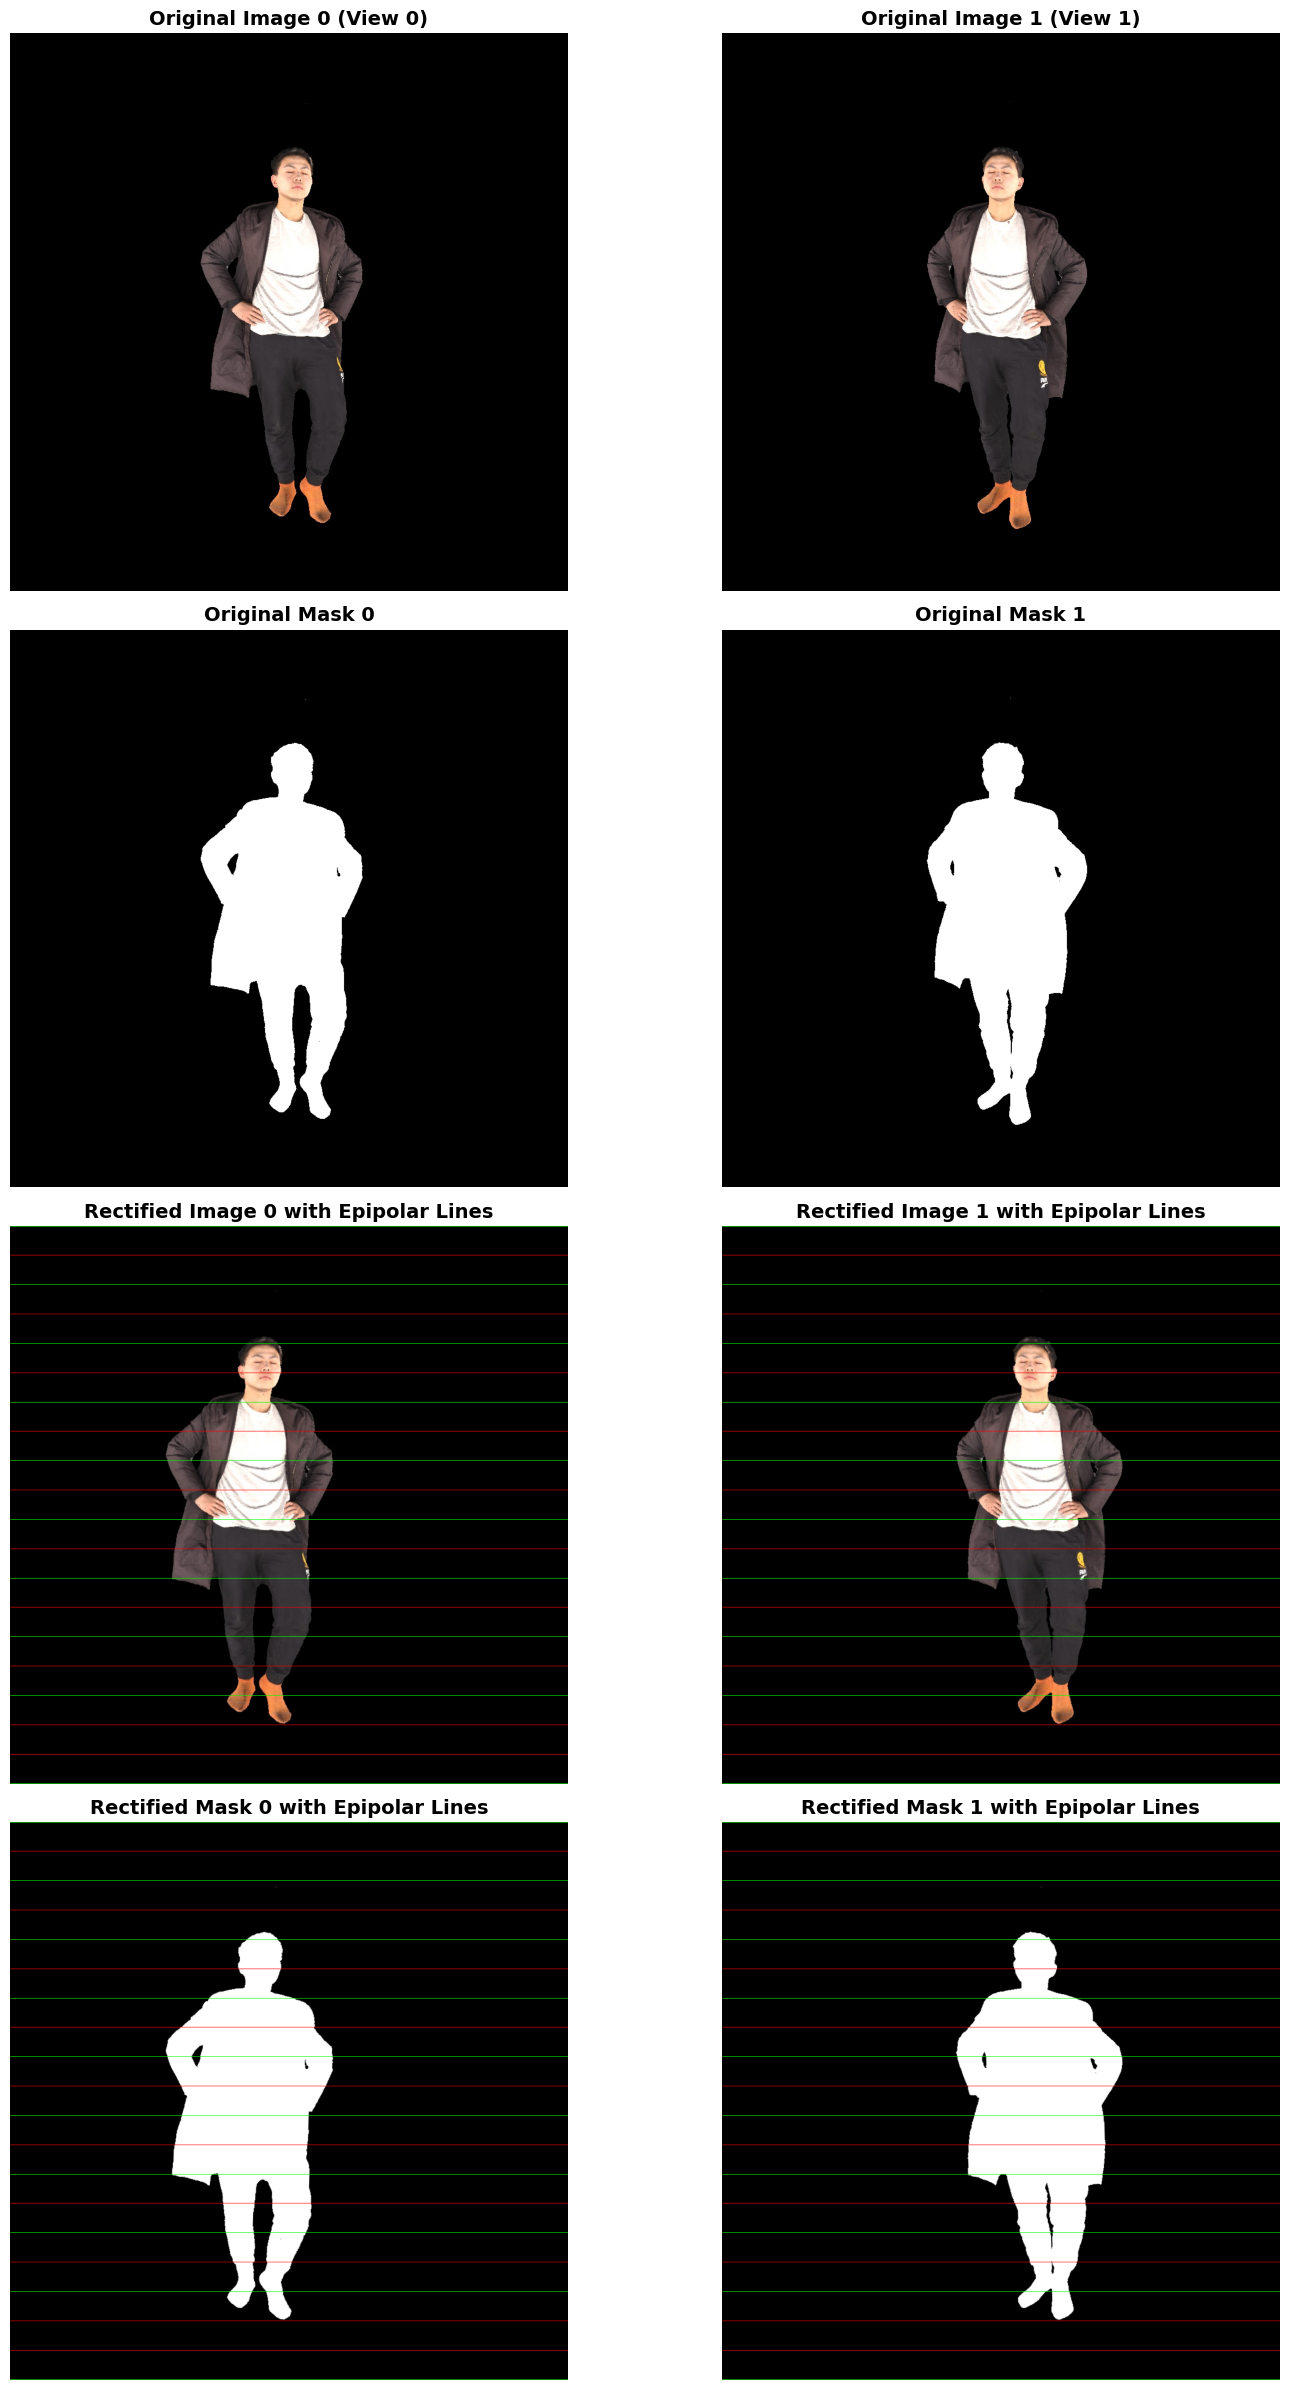

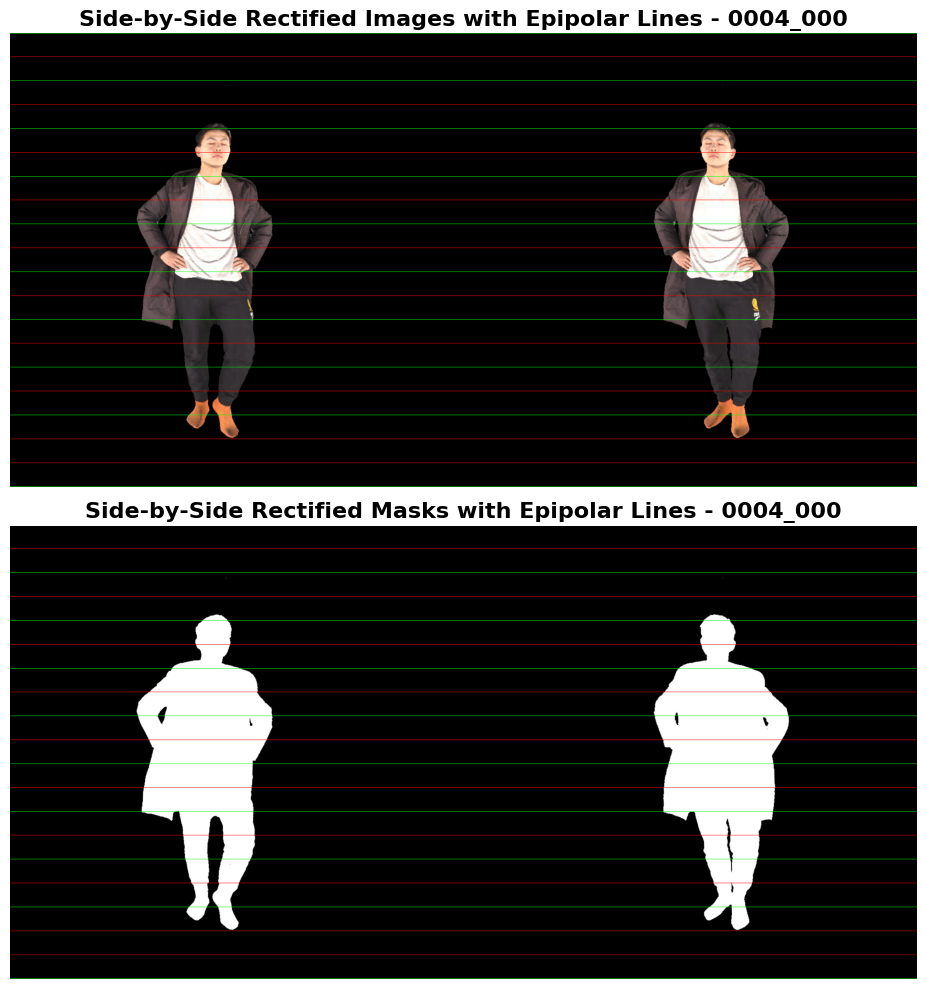


✓ Rectification complete!

How to verify rectification quality:
1. Corresponding points in both images should lie on the same horizontal line
2. The colored horizontal lines should align perfectly across both images
3. Any vertical disparity indicates poor rectification
4. Mask boundaries should also align on the same horizontal lines


In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def load_camera_params(data_root, view_name, view_id):
    """Load camera parameters for a specific view"""
    intr_path = os.path.join(data_root, 'parm', view_name, f'{view_id}_intrinsic.npy')
    extr_path = os.path.join(data_root, 'parm', view_name, f'{view_id}_extrinsic.npy')
    
    intrinsic = np.load(intr_path)
    extrinsic = np.load(extr_path)
    
    return intrinsic, extrinsic

def load_image_and_mask(data_root, view_name, view_id):
    """Load image and mask for a specific view"""
    img_path = os.path.join(data_root, 'img', view_name, f'{view_id}.jpg')
    mask_path = os.path.join(data_root, 'mask', view_name, f'{view_id}.png')
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]
    
    return img, mask

def rectify_stereo_pair(img0, mask0, intr0, extr0, img1, mask1, intr1, extr1):
    """
    Rectify a stereo pair (images and masks) using OpenCV stereoRectify
    Based on get_rectified_stereo_data() from human_loader.py
    """
    H, W = img0.shape[:2]
    
    # Extract rotation and translation
    r0, t0 = extr0[:3, :3], extr0[:3, 3:]
    r1, t1 = extr1[:3, :3], extr1[:3, 3:]
    
    # Compute relative pose (camera 0 to camera 1)
    # Invert camera 0: world-to-cam0 -> cam0-to-world
    inv_r0 = r0.T
    inv_t0 = -r0.T @ t0
    E0 = np.eye(4)
    E0[:3, :3], E0[:3, 3:] = inv_r0, inv_t0
    
    # Camera 1 world-to-cam
    E1 = np.eye(4)
    E1[:3, :3], E1[:3, 3:] = r1, t1
    
    # Relative transformation: cam0 to cam1
    E = E1 @ E0
    R, T = E[:3, :3], E[:3, 3]
    
    # No distortion
    dist0 = np.zeros(4)
    dist1 = np.zeros(4)
    
    # Stereo rectification
    R0, R1, P0, P1, Q, roi0, roi1 = cv2.stereoRectify(
        intr0, dist0, intr1, dist1, (W, H), R, T, flags=0
    )
    
    # Compute rectification maps
    map0_x, map0_y = cv2.initUndistortRectifyMap(intr0, dist0, R0, P0, (W, H), cv2.CV_32FC1)
    map1_x, map1_y = cv2.initUndistortRectifyMap(intr1, dist1, R1, P1, (W, H), cv2.CV_32FC1)
    
    # Remap images
    rect_img0 = cv2.remap(img0, map0_x, map0_y, cv2.INTER_LINEAR)
    rect_img1 = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    
    # Remap masks
    rect_mask0 = cv2.remap(mask0, map0_x, map0_y, cv2.INTER_LINEAR)
    rect_mask1 = cv2.remap(mask1, map1_x, map1_y, cv2.INTER_LINEAR)
    
    return rect_img0, rect_mask0, rect_img1, rect_mask1, R0, R1, P0, P1

def draw_epipolar_lines(img0, img1, num_lines=20):
    """
    Draw horizontal epipolar lines on both images for verification
    """
    H, W = img0.shape[:2]
    
    # Create copies to draw on
    img0_lines = img0.copy()
    img1_lines = img1.copy()
    
    # Draw horizontal lines at regular intervals
    line_positions = np.linspace(0, H-1, num_lines, dtype=int)
    
    for y in line_positions:
        # Alternate colors for better visibility
        color = (0, 255, 0) if (y // (H // num_lines)) % 2 == 0 else (255, 0, 0)
        cv2.line(img0_lines, (0, y), (W-1, y), color, 1)
        cv2.line(img1_lines, (0, y), (W-1, y), color, 1)
    
    return img0_lines, img1_lines

# Set paths
data_root = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train'
view_name = '0004_000'

print(f"Processing {view_name}...")

# Load data for view 0 and view 1
img0, mask0 = load_image_and_mask(data_root, view_name, 0)
intr0, extr0 = load_camera_params(data_root, view_name, 0)

img1, mask1 = load_image_and_mask(data_root, view_name, 1)
intr1, extr1 = load_camera_params(data_root, view_name, 1)

print(f"Image 0 shape: {img0.shape}")
print(f"Image 1 shape: {img1.shape}")
print(f"Mask 0 shape: {mask0.shape}, unique values: {np.unique(mask0)}")
print(f"Mask 1 shape: {mask1.shape}, unique values: {np.unique(mask1)}")
print(f"Intrinsic 0:\n{intr0}")
print(f"Intrinsic 1:\n{intr1}")

# Compute camera separation
r0, t0 = extr0[:3, :3], extr0[:3, 3]
r1, t1 = extr1[:3, :3], extr1[:3, 3]
C0 = -r0.T @ t0
C1 = -r1.T @ t1
baseline = np.linalg.norm(C1 - C0)
print(f"\nBaseline distance: {baseline:.6f} units")

# Rectify stereo pair (images and masks)
print("\nRectifying stereo pair...")
rect_img0, rect_mask0, rect_img1, rect_mask1, R0, R1, P0, P1 = rectify_stereo_pair(
    img0, mask0, intr0, extr0, img1, mask1, intr1, extr1
)

print(f"Rectification matrices computed")
print(f"New projection matrix P0:\n{P0}")
print(f"New projection matrix P1:\n{P1}")

# Draw epipolar lines on images
img0_with_lines, img1_with_lines = draw_epipolar_lines(rect_img0, rect_img1, num_lines=20)

# Create visualization
fig, axes = plt.subplots(4, 2, figsize=(16, 24))

# Row 0: Original images
axes[0, 0].imshow(img0)
axes[0, 0].set_title('Original Image 0 (View 0)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(img1)
axes[0, 1].set_title('Original Image 1 (View 1)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# Row 1: Original masks
axes[1, 0].imshow(mask0, cmap='gray')
axes[1, 0].set_title('Original Mask 0', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask1, cmap='gray')
axes[1, 1].set_title('Original Mask 1', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# Row 2: Rectified images with epipolar lines
axes[2, 0].imshow(img0_with_lines)
axes[2, 0].set_title('Rectified Image 0 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[2, 0].axis('off')

axes[2, 1].imshow(img1_with_lines)
axes[2, 1].set_title('Rectified Image 1 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[2, 1].axis('off')

# Row 3: Rectified masks with epipolar lines
mask0_rgb = cv2.cvtColor(rect_mask0, cv2.COLOR_GRAY2RGB)
mask1_rgb = cv2.cvtColor(rect_mask1, cv2.COLOR_GRAY2RGB)
mask0_with_lines, mask1_with_lines = draw_epipolar_lines(mask0_rgb, mask1_rgb, num_lines=20)

axes[3, 0].imshow(mask0_with_lines)
axes[3, 0].set_title('Rectified Mask 0 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[3, 0].axis('off')

axes[3, 1].imshow(mask1_with_lines)
axes[3, 1].set_title('Rectified Mask 1 with Epipolar Lines', fontsize=14, fontweight='bold')
axes[3, 1].axis('off')

plt.tight_layout()
plt.show()

# Create side-by-side comparisons
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# Side-by-side rectified images
combined_img = np.hstack([img0_with_lines, img1_with_lines])
axes[0].imshow(combined_img)
axes[0].set_title(f'Side-by-Side Rectified Images with Epipolar Lines - {view_name}', 
                  fontsize=16, fontweight='bold')
axes[0].axis('off')

# Side-by-side rectified masks
combined_mask = np.hstack([mask0_with_lines, mask1_with_lines])
axes[1].imshow(combined_mask)
axes[1].set_title(f'Side-by-Side Rectified Masks with Epipolar Lines - {view_name}', 
                  fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Rectification complete!")
print("\nHow to verify rectification quality:")
print("1. Corresponding points in both images should lie on the same horizontal line")
print("2. The colored horizontal lines should align perfectly across both images")
print("3. Any vertical disparity indicates poor rectification")
print("4. Mask boundaries should also align on the same horizontal lines")

=== Mask Analysis ===
Mask shape: (1024, 1024), dtype: uint8
Mask unique values: [  0 255]
Mask range: [0, 255]
Number of masked pixels (>128): 110499
Percentage masked: 10.54%

=== Inverse Depth Analysis (all pixels) ===
Inv depth shape: (1024, 1024), dtype: float32
Inv depth range: [0.000000, 0.551880]
Non-zero inv depth pixels: 110499

=== Inverse Depth Analysis (masked pixels only) ===
Masked inv depth range: [0.443726, 0.551880]
Masked inv depth mean: 0.507833
Masked inv depth median: 0.510193

=== Actual Depth (masked, filtered) ===
Depth range: [1.812, 2.254] meters
Depth mean: 1.972 meters
Depth median: 1.960 meters


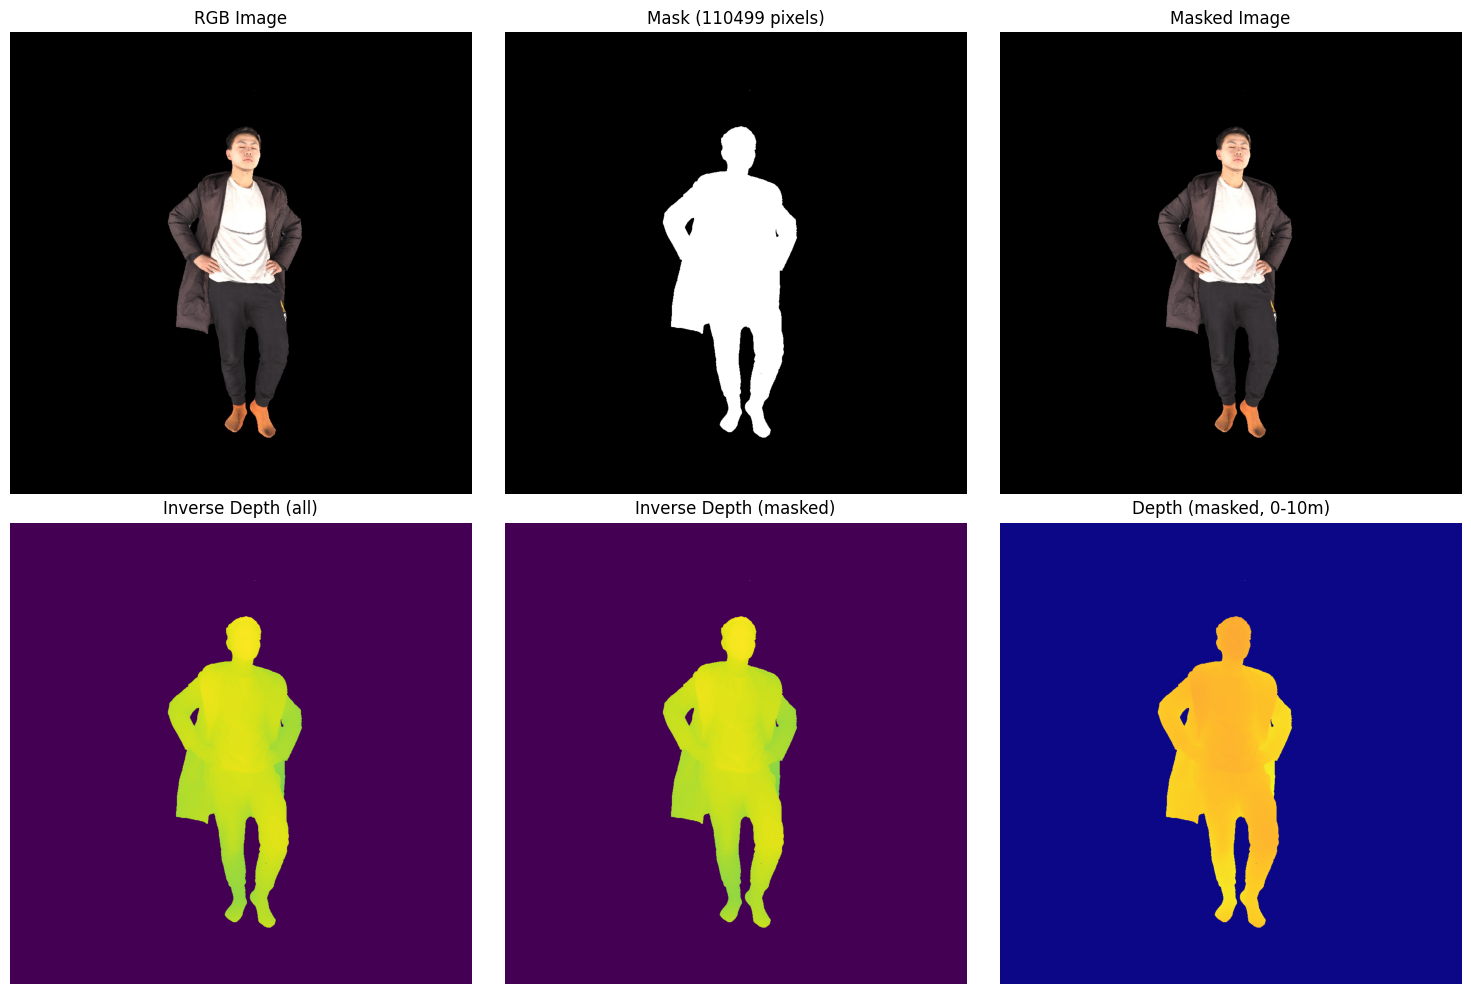

In [1]:
# Let's first visualize the mask, depth, and image together to understand the data
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Set base path
base_path = os.path.join('render_data', 'render_data', 'train', 'parm')
if not os.path.exists(base_path):
    base_path = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train\parm'

train_root = os.path.dirname(base_path)
view_name = '0004_000'

img_path = os.path.join(train_root, 'img', view_name, '0.jpg')
mask_path = os.path.join(train_root, 'mask', view_name, '0.png')
depth_path = os.path.join(train_root, 'depth', view_name, '0.png')

# Load data
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
if len(mask.shape) > 2:
    mask = mask[:, :, 0]

depth_raw = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
inv_depth = depth_raw / (2.0 ** 15)

# Analyze mask
print("=== Mask Analysis ===")
print(f"Mask shape: {mask.shape}, dtype: {mask.dtype}")
print(f"Mask unique values: {np.unique(mask)}")
print(f"Mask range: [{mask.min()}, {mask.max()}]")
print(f"Number of masked pixels (>128): {np.sum(mask > 128)}")
print(f"Percentage masked: {100 * np.sum(mask > 128) / mask.size:.2f}%")

# Analyze inverse depth
print(f"\n=== Inverse Depth Analysis (all pixels) ===")
print(f"Inv depth shape: {inv_depth.shape}, dtype: {inv_depth.dtype}")
print(f"Inv depth range: [{inv_depth.min():.6f}, {inv_depth.max():.6f}]")
print(f"Non-zero inv depth pixels: {np.sum(inv_depth > 0)}")

# Analyze inverse depth within mask
masked_inv_depth = inv_depth[mask > 128]
print(f"\n=== Inverse Depth Analysis (masked pixels only) ===")
print(f"Masked inv depth range: [{masked_inv_depth.min():.6f}, {masked_inv_depth.max():.6f}]")
print(f"Masked inv depth mean: {masked_inv_depth.mean():.6f}")
print(f"Masked inv depth median: {np.median(masked_inv_depth):.6f}")

# Convert to actual depth for masked pixels
masked_depth = 1.0 / (masked_inv_depth + 1e-8)
masked_depth = masked_depth[masked_depth < 100]  # Filter out extreme values
print(f"\n=== Actual Depth (masked, filtered) ===")
print(f"Depth range: [{masked_depth.min():.3f}, {masked_depth.max():.3f}] meters")
print(f"Depth mean: {masked_depth.mean():.3f} meters")
print(f"Depth median: {np.median(masked_depth):.3f} meters")

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('RGB Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(mask, cmap='gray')
axes[0, 1].set_title(f'Mask ({np.sum(mask > 128)} pixels)')
axes[0, 1].axis('off')

axes[0, 2].imshow(img * (mask[:, :, np.newaxis] > 128))
axes[0, 2].set_title('Masked Image')
axes[0, 2].axis('off')

axes[1, 0].imshow(inv_depth, cmap='viridis')
axes[1, 0].set_title('Inverse Depth (all)')
axes[1, 0].axis('off')

masked_inv_depth_vis = np.zeros_like(inv_depth)
masked_inv_depth_vis[mask > 128] = inv_depth[mask > 128]
axes[1, 1].imshow(masked_inv_depth_vis, cmap='viridis')
axes[1, 1].set_title('Inverse Depth (masked)')
axes[1, 1].axis('off')

# Depth visualization (clipped for visibility)
depth_vis = 1.0 / (inv_depth + 1e-8)
depth_vis = np.clip(depth_vis, 0, 10)  # Clip to 10m for visualization
depth_vis[mask <= 128] = 0
axes[1, 2].imshow(depth_vis, cmap='plasma')
axes[1, 2].set_title('Depth (masked, 0-10m)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [2]:
import cv2
import open3d as o3d

# First, let's check a depth map to verify if it's inverse depth or regular depth
def read_depth(name):
    # Based on lib/human_loader.py: returns inverse depth (1/Z)
    return cv2.imread(name, cv2.IMREAD_UNCHANGED).astype(np.float32) / 2.0 ** 15

def depth2pts_np(inv_depth_map, extrinsic, intrinsic, mask=None):
    """
    Convert inverse depth map to 3D points in world coordinates
    
    Args:
        inv_depth_map: HxW inverse depth map (1/Z format)
        extrinsic: 3x4 or 4x4 [R|t] matrix (World -> Camera transformation)
        intrinsic: 3x3 camera intrinsic matrix
        mask: Optional binary mask to filter valid pixels
    
    Returns:
        pts_world: (N, 3) array of 3D points in world coordinates
        Z_vals: (N,) array of depth values
    """
    H, W = inv_depth_map.shape
    
    # Create pixel coordinate grid
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    
    # Filter by mask first if provided
    if mask is not None:
        valid_mask = mask > 128
        # Also filter out very small inverse depth (far away / invalid)
        valid_mask &= (inv_depth_map > 0.05)  # Corresponds to depth < 20m
    else:
        valid_mask = inv_depth_map > 0.05
    
    # Apply mask to get valid pixels
    u_valid = u[valid_mask]
    v_valid = v[valid_mask]
    inv_depth_valid = inv_depth_map[valid_mask]
    
    # Convert inverse depth to depth
    Z = 1.0 / (inv_depth_valid + 1e-8)
    
    # Print depth range statistics
    print(f"\n=== Depth Range Statistics (masked pixels only) ===")
    print(f"Valid pixels: {len(Z)} out of {H*W}")
    print(f"Inverse depth - Min: {inv_depth_valid.min():.6f}, Max: {inv_depth_valid.max():.6f}, Mean: {inv_depth_valid.mean():.6f}")
    print(f"Depth (Z) - Min: {Z.min():.3f}, Max: {Z.max():.3f}, Mean: {Z.mean():.3f}, Median: {np.median(Z):.3f}")
    print(f"Depth percentiles:")
    for p in [10, 25, 50, 75, 90, 95, 99]:
        print(f"  {p}%: {np.percentile(Z, p):.3f}")
    
    # Extract intrinsic parameters
    fx = intrinsic[0, 0]
    fy = intrinsic[1, 1]
    cx = intrinsic[0, 2]
    cy = intrinsic[1, 2]
    
    # Unproject pixels to 3D camera coordinates
    X_cam = (u_valid - cx) * Z / fx
    Y_cam = (v_valid - cy) * Z / fy
    
    # Stack into camera coordinate points (N, 3)
    P_cam = np.vstack((X_cam, Y_cam, Z))  # (3, N)
    
    # Transform from camera coordinates to world coordinates
    # Camera to world: P_world = R^T * (P_cam - t)
    # Where [R|t] is the world-to-camera extrinsic matrix
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3].reshape(3, 1)
    
    P_world = np.dot(R.T, (P_cam - t))  # (3, N)
    
    return P_world.T, Z  # Return (N, 3) and (N,)


# Setup paths
train_root = os.path.dirname(base_path)  # base_path points to parm folder
view_name = '0004_000'

img_path = os.path.join(train_root, 'img', view_name, '0.jpg')
mask_path = os.path.join(train_root, 'mask', view_name, '0.png')
depth_path = os.path.join(train_root, 'depth', view_name, '0.png')
ext_path = os.path.join(train_root, 'parm', view_name, '0_extrinsic.npy')
int_path = os.path.join(train_root, 'parm', view_name, '0_intrinsic.npy')

if os.path.exists(img_path) and os.path.exists(depth_path):
    print(f"Loading data from {view_name}...")
    
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load mask
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    if len(mask.shape) > 2:
        mask = mask[:, :, 0]
    
    # Load inverse depth
    inv_depth = read_depth(depth_path)
    
    # Load camera parameters (OpenCV format)
    extrinsic = np.load(ext_path)
    intrinsic = np.load(int_path)
    
    print(f"\n=== Data Shapes ===")
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    print(f"Inverse depth shape: {inv_depth.shape}")
    print(f"\n=== Inverse Depth (raw) Statistics ===")
    print(f"Min={inv_depth.min():.6f}, Max={inv_depth.max():.6f}, Mean={inv_depth.mean():.6f}")
    print(f"\n=== Camera Parameters ===")
    print(f"Extrinsic matrix shape: {extrinsic.shape}")
    print(f"Intrinsic matrix:\n{intrinsic}")
    
    # Generate 3D point cloud with proper masking
    pts_world, Z_vals = depth2pts_np(inv_depth, extrinsic, intrinsic, mask=mask)
    
    # Get colors for valid points
    # Create a flat index for valid pixels
    H, W = inv_depth.shape
    u, v = np.meshgrid(np.arange(W), np.arange(H))
    valid_mask = (mask > 128) & (inv_depth > 0.05)
    valid_colors = img[valid_mask]
    
    print(f"\n=== Point Cloud Info ===")
    print(f"Generated {len(pts_world)} valid points")
    print(f"Point cloud bounds (world coordinates):")
    print(f"  X: [{pts_world[:,0].min():.3f}, {pts_world[:,0].max():.3f}]")
    print(f"  Y: [{pts_world[:,1].min():.3f}, {pts_world[:,1].max():.3f}]")
    print(f"  Z: [{pts_world[:,2].min():.3f}, {pts_world[:,2].max():.3f}]")
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_world)
    pcd.colors = o3d.utility.Vector3dVector(valid_colors / 255.0)
    
    # Save to PLY file
    ply_out = 'point_cloud_0004_000_view0.ply'
    o3d.io.write_point_cloud(ply_out, pcd)
    print(f"\nSaved point cloud to {ply_out}")
    
    # Visualize with Open3D
    print("\nOpening Open3D visualizer...")
    print("Controls: Mouse to rotate, scroll to zoom, Ctrl+C in terminal to close")
    o3d.visualization.draw_geometries([pcd], 
                                      window_name=f"Point Cloud: {view_name}",
                                      width=1024, 
                                      height=768)
    
else:
    print(f"Files not found.")
    print(f"Checked paths:")
    print(f"  Image: {img_path}")
    print(f"  Depth: {depth_path}")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading data from 0004_000...

=== Data Shapes ===
Image shape: (1024, 1024, 3)
Mask shape: (1024, 1024)
Inverse depth shape: (1024, 1024)

=== Inverse Depth (raw) Statistics ===
Min=0.000000, Max=0.551880, Mean=0.053515

=== Camera Parameters ===
Extrinsic matrix shape: (3, 4)
Intrinsic matrix:
[[819.2   0.  512. ]
 [  0.  819.2 537. ]
 [  0.    0.    1. ]]

=== Depth Range Statistics (masked pixels only) ===
Valid pixels: 110499 out of 1048576
Inverse depth - Min: 0.443726, Max: 0.551880, Mean: 0.507833
Depth (Z) - Min: 1.812, Max: 2.254, Mean: 1.972, Median: 1.960
Depth percentiles:
  10%: 1.894
  25%: 1.916
  50%: 1.960
  75%: 2.020
  90%: 2.075
  95%: 2.110
  99%: 2.167

=== Point Cloud Info ===
Generated 110499 valid points
Point cloud bounds (world coordinates):
  X: [-0.368, 0.381]
  Y: [0.000, 1.787]
  Z: [-0.1

In [4]:
import numpy as np
import os
import math

def get_camera_center(extrinsic):
    # extrinsic is 4x4 assuming [R|t]
    if extrinsic.shape == (3, 4):
        extrinsic = np.vstack([extrinsic, [0, 0, 0, 1]])
    
    R = extrinsic[:3, :3]
    t = extrinsic[:3, 3]
    C = -np.dot(R.T, t)
    return C

def get_rotation_angle(R1, R2):
    R_diff = np.dot(R1, R2.T)
    val = (np.trace(R_diff) - 1) / 2
    val = np.clip(val, -1.0, 1.0)
    return math.acos(val) * 180.0 / math.pi

# Adjust this path if necessary relative to where the notebook is running
base_path = os.path.join('render_data', 'render_data', 'train', 'parm')
# Using absolute path from context if relative fails to verify
if not os.path.exists(base_path):
    base_path = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train\parm'

targets = ['0004_000', '0005_000', '0006_000']

for target in targets:
    folder_path = os.path.join(base_path, target)
    if not os.path.exists(folder_path):
        print(f"Folder {target} does not exist.")
        continue
    
    file_0 = os.path.join(folder_path, '0_extrinsic.npy')
    file_1 = os.path.join(folder_path, '1_extrinsic.npy')

    if not os.path.exists(file_0) or not os.path.exists(file_1):
        print(f"Files missing in {target}")
        continue

    ext0 = np.load(file_0)
    ext1 = np.load(file_1)

    C0 = get_camera_center(ext0)
    C1 = get_camera_center(ext1)

    dist = np.linalg.norm(C0 - C1)

    R0 = ext0[:3, :3]
    R1 = ext1[:3, :3]

    angle = get_rotation_angle(R0, R1)

    print(f"--- {target} ---")
    print(f"Distance between camera 0 and 1: {dist:.6f}")
    print(f"Orientation difference (degrees): {angle:.6f}")
    print(f'extrinsic 0:\n{ext0}')
    print(f'extrinsic 1:\n{ext1}')

--- 0004_000 ---
Distance between camera 0 and 1: 0.788222
Orientation difference (degrees): 22.500000
extrinsic 0:
[[ 9.39376900e-01  0.00000000e+00  3.42886335e-01 -6.39455410e-17]
 [-4.77205546e-02 -9.90268069e-01  1.30735996e-01  8.41727858e-01]
 [ 3.39549389e-01 -1.39173101e-01 -9.30234949e-01  2.15829714e+00]]
extrinsic 1:
[[ 9.99088011e-01  0.00000000e+00 -4.26983094e-02 -8.78143096e-18]
 [ 5.94245612e-03 -9.90268069e-01  1.39046177e-01  8.41727858e-01]
 [-4.22827724e-02 -1.39173101e-01 -9.89364955e-01  2.15829714e+00]]
--- 0005_000 ---
Distance between camera 0 and 1: 0.788222
Orientation difference (degrees): 22.500000
extrinsic 0:
[[-8.65225961e-01 -0.00000000e+00 -5.01382125e-01 -1.26841073e-16]
 [ 6.97789051e-02 -9.90268069e-01 -1.20416180e-01  8.41727858e-01]
 [-4.96502709e-01 -1.39173101e-01  8.56805642e-01  2.15829714e+00]]
extrinsic 1:
[[-9.91235189e-01 -0.00000000e+00 -1.32109043e-01 -2.45368232e-17]
 [ 1.83860252e-02 -9.90268069e-01 -1.37953275e-01  8.41727858e-01]
 [

Original inverse depth shapes: (1024, 1024), (1024, 1024)
Original inverse depth ranges:
  View 0: [0.0000, 0.5519]
  View 1: [0.0000, 0.5528]

Baseline (distance between cameras): 0.7882

Rectified inverse depth shapes: (1024, 1024), (1024, 1024)
Rectified inverse depth ranges:
  View 0: [0.0000, 0.5518]
  View 1: [0.0000, 0.5521]

Rectified camera parameters:
  fx': 819.20, fy': 819.20

Disparity ranges (in pixels):
  View 0: [0.00, 356.30]
  View 1: [0.00, 356.47]

Masked inverse depth statistics:
  View 0: mean=0.5077, median=0.5142
  View 1: mean=0.5018, median=0.5124

Masked disparity statistics (pixels):
  View 0: mean=327.27, median=332.02
  View 1: mean=323.36, median=330.83

Actual depth statistics (meters):
  View 0: mean=2.00m, median=1.94m
  View 1: mean=2.03m, median=1.95m


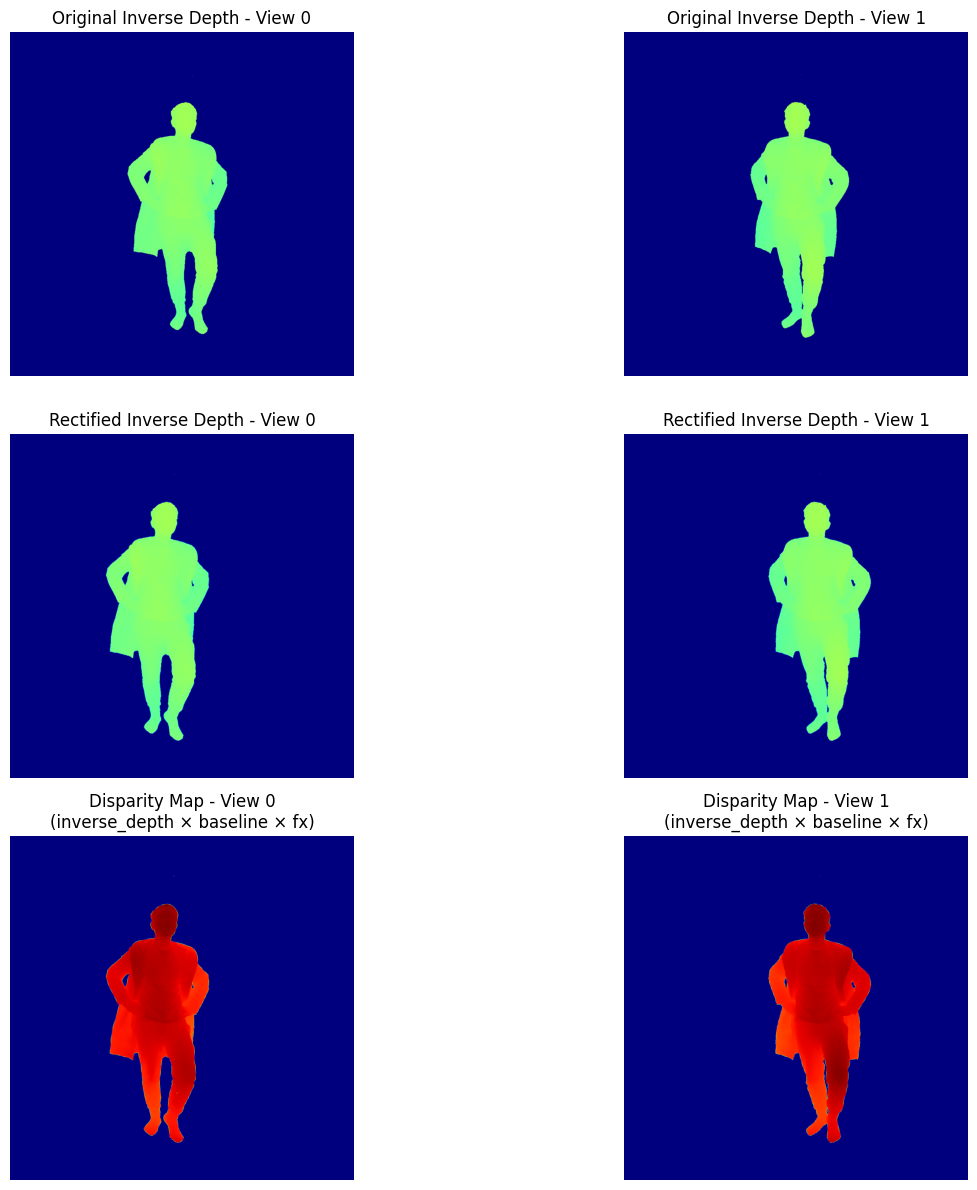


EXPLANATION:
1. INVERSE DEPTH: Stored as 1/Z (where Z is depth in meters)
   - Original: In unrectified camera coordinates
   - Rectified: After stereo rectification (epipolar lines horizontal)

2. DISPARITY: Horizontal pixel offset between corresponding points
   - Formula: disparity = inverse_depth × baseline × focal_length
   - Unit: pixels
   - Only meaningful for rectified images

3. RELATIONSHIP:
   - For this stereo pair:
     • Baseline = 0.7882 (distance between cameras)
     • Focal length (rectified) = 819.20 pixels
     • Scaling factor = 645.71
   - So: disparity ≈ inverse_depth × 645.71

4. GROUND TRUTH:
   - Rectified inverse depth maps ARE the ground truth for rectified images
   - They can be converted to disparity using the formula above
   - Useful for training stereo matching networks


In [7]:
# Rectify inverse depth maps and understand their relationship to disparity
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def load_inverse_depth(data_root, view_name, view_id):
    """Load inverse depth map (stored as uint16/2^15)"""
    depth_path = os.path.join(data_root, 'depth', view_name, f'{view_id}.png')
    inv_depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED).astype(np.float32) / (2**15)
    return inv_depth

def rectify_inverse_depth(inv_depth, map_x, map_y):
    """
    Rectify an inverse depth map using the same rectification maps as images
    """
    rect_inv_depth = cv2.remap(inv_depth, map_x, map_y, cv2.INTER_LINEAR)
    return rect_inv_depth

def inverse_depth_to_disparity(inv_depth, baseline, focal_length):
    """
    Convert inverse depth (1/Z) to disparity (pixels)
    
    For rectified stereo:
    - Disparity d = x_left - x_right (horizontal pixel difference)
    - Depth Z = (baseline * focal_length) / disparity
    - Therefore: disparity = baseline * focal_length / Z = baseline * focal_length * (1/Z)
    - So: disparity = inverse_depth * baseline * focal_length
    
    Args:
        inv_depth: Inverse depth map (1/Z)
        baseline: Distance between camera centers (meters or whatever unit)
        focal_length: Focal length in pixels (fx from rectified camera matrix)
    
    Returns:
        disparity: Disparity in pixels
    """
    disparity = inv_depth * baseline * focal_length
    return disparity

# Load the data
data_root = r'd:\GitHub\GPS-Gaussian\render_data\render_data\train'
view_name = '0004_000'
view_id_0 = 0
view_id_1 = 1

# Load camera parameters
intr0, extr0 = load_camera_params(data_root, view_name, view_id_0)
intr1, extr1 = load_camera_params(data_root, view_name, view_id_1)

# Load images and masks
img0, mask0 = load_image_and_mask(data_root, view_name, view_id_0)
img1, mask1 = load_image_and_mask(data_root, view_name, view_id_1)

# Load inverse depth maps
inv_depth0 = load_inverse_depth(data_root, view_name, view_id_0)
inv_depth1 = load_inverse_depth(data_root, view_name, view_id_1)

print(f"Original inverse depth shapes: {inv_depth0.shape}, {inv_depth1.shape}")
print(f"Original inverse depth ranges:")
print(f"  View 0: [{inv_depth0.min():.4f}, {inv_depth0.max():.4f}]")
print(f"  View 1: [{inv_depth1.min():.4f}, {inv_depth1.max():.4f}]")

# Perform rectification (same as before, but now we also need the maps)
H, W = img0.shape[:2]

# Extract rotation and translation
r0, t0 = extr0[:3, :3], extr0[:3, 3:]
r1, t1 = extr1[:3, :3], extr1[:3, 3:]

# Compute relative pose
inv_r0 = r0.T
inv_t0 = -r0.T @ t0
E0 = np.eye(4)
E0[:3, :3], E0[:3, 3:] = inv_r0, inv_t0

E1 = np.eye(4)
E1[:3, :3], E1[:3, 3:] = r1, t1

E = E1 @ E0
R, T = E[:3, :3], E[:3, 3]

# Calculate baseline (Euclidean distance between camera centers)
# Camera 0 center: inv_t0
# Camera 1 center: -r1.T @ t1
cam0_center = inv_t0.flatten()
cam1_center = (-r1.T @ t1).flatten()
baseline = np.linalg.norm(cam1_center - cam0_center)
print(f"\nBaseline (distance between cameras): {baseline:.4f}")

# No distortion
dist0 = np.zeros(4)
dist1 = np.zeros(4)

# Stereo rectification
R0, R1, P0, P1, Q, roi0, roi1 = cv2.stereoRectify(
    intr0, dist0, intr1, dist1, (W, H), R, T, flags=0
)

# Compute rectification maps
map0_x, map0_y = cv2.initUndistortRectifyMap(intr0, dist0, R0, P0, (W, H), cv2.CV_32FC1)
map1_x, map1_y = cv2.initUndistortRectifyMap(intr1, dist1, R1, P1, (W, H), cv2.CV_32FC1)

# Rectify inverse depth maps
rect_inv_depth0 = rectify_inverse_depth(inv_depth0, map0_x, map0_y)
rect_inv_depth1 = rectify_inverse_depth(inv_depth1, map1_x, map1_y)

print(f"\nRectified inverse depth shapes: {rect_inv_depth0.shape}, {rect_inv_depth1.shape}")
print(f"Rectified inverse depth ranges:")
print(f"  View 0: [{rect_inv_depth0.min():.4f}, {rect_inv_depth0.max():.4f}]")
print(f"  View 1: [{rect_inv_depth1.min():.4f}, {rect_inv_depth1.max():.4f}]")

# Convert to disparity using rectified focal length
# P0 and P1 are the rectified projection matrices [fx' 0 cx' 0; 0 fy' cy' 0; 0 0 1 0]
fx_rect = P0[0, 0]
fy_rect = P0[1, 1]
print(f"\nRectified camera parameters:")
print(f"  fx': {fx_rect:.2f}, fy': {fy_rect:.2f}")

# Convert rectified inverse depth to disparity
disparity0 = inverse_depth_to_disparity(rect_inv_depth0, baseline, fx_rect)
disparity1 = inverse_depth_to_disparity(rect_inv_depth1, baseline, fx_rect)

print(f"\nDisparity ranges (in pixels):")
print(f"  View 0: [{disparity0.min():.2f}, {disparity0.max():.2f}]")
print(f"  View 1: [{disparity1.min():.2f}, {disparity1.max():.2f}]")

# Filter by mask to get meaningful statistics
mask0_bool = mask0 > 128
mask1_bool = mask1 > 128

valid_inv_depth0 = rect_inv_depth0[mask0_bool]
valid_inv_depth1 = rect_inv_depth1[mask1_bool]
valid_disparity0 = disparity0[mask0_bool]
valid_disparity1 = disparity1[mask1_bool]

# Filter out zero/very small values
valid_inv_depth0 = valid_inv_depth0[valid_inv_depth0 > 0.05]
valid_inv_depth1 = valid_inv_depth1[valid_inv_depth1 > 0.05]
valid_disparity0 = valid_disparity0[valid_disparity0 > 0]
valid_disparity1 = valid_disparity1[valid_disparity1 > 0]

print(f"\nMasked inverse depth statistics:")
print(f"  View 0: mean={valid_inv_depth0.mean():.4f}, median={np.median(valid_inv_depth0):.4f}")
print(f"  View 1: mean={valid_inv_depth1.mean():.4f}, median={np.median(valid_inv_depth1):.4f}")
print(f"\nMasked disparity statistics (pixels):")
print(f"  View 0: mean={valid_disparity0.mean():.2f}, median={np.median(valid_disparity0):.2f}")
print(f"  View 1: mean={valid_disparity1.mean():.2f}, median={np.median(valid_disparity1):.2f}")

# Convert to actual depth for reference
valid_depth0 = 1.0 / valid_inv_depth0
valid_depth1 = 1.0 / valid_inv_depth1
print(f"\nActual depth statistics (meters):")
print(f"  View 0: mean={valid_depth0.mean():.2f}m, median={np.median(valid_depth0):.2f}m")
print(f"  View 1: mean={valid_depth1.mean():.2f}m, median={np.median(valid_depth1):.2f}m")

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Row 1: Original inverse depth
axes[0, 0].imshow(inv_depth0, cmap='jet', vmin=0, vmax=1)
axes[0, 0].set_title(f'Original Inverse Depth - View {view_id_0}')
axes[0, 0].axis('off')

axes[0, 1].imshow(inv_depth1, cmap='jet', vmin=0, vmax=1)
axes[0, 1].set_title(f'Original Inverse Depth - View {view_id_1}')
axes[0, 1].axis('off')

# Row 2: Rectified inverse depth
axes[1, 0].imshow(rect_inv_depth0, cmap='jet', vmin=0, vmax=1)
axes[1, 0].set_title(f'Rectified Inverse Depth - View {view_id_0}')
axes[1, 0].axis('off')

axes[1, 1].imshow(rect_inv_depth1, cmap='jet', vmin=0, vmax=1)
axes[1, 1].set_title(f'Rectified Inverse Depth - View {view_id_1}')
axes[1, 1].axis('off')

# Row 3: Disparity maps
disp_max = max(disparity0.max(), disparity1.max())
axes[2, 0].imshow(disparity0, cmap='jet', vmin=0, vmax=disp_max)
axes[2, 0].set_title(f'Disparity Map - View {view_id_0}\n(inverse_depth × baseline × fx)')
axes[2, 0].axis('off')

axes[2, 1].imshow(disparity1, cmap='jet', vmin=0, vmax=disp_max)
axes[2, 1].set_title(f'Disparity Map - View {view_id_1}\n(inverse_depth × baseline × fx)')
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EXPLANATION:")
print("="*70)
print("1. INVERSE DEPTH: Stored as 1/Z (where Z is depth in meters)")
print("   - Original: In unrectified camera coordinates")
print("   - Rectified: After stereo rectification (epipolar lines horizontal)")
print()
print("2. DISPARITY: Horizontal pixel offset between corresponding points")
print("   - Formula: disparity = inverse_depth × baseline × focal_length")
print("   - Unit: pixels")
print("   - Only meaningful for rectified images")
print()
print("3. RELATIONSHIP:")
print(f"   - For this stereo pair:")
print(f"     • Baseline = {baseline:.4f} (distance between cameras)")
print(f"     • Focal length (rectified) = {fx_rect:.2f} pixels")
print(f"     • Scaling factor = {baseline * fx_rect:.2f}")
print(f"   - So: disparity ≈ inverse_depth × {baseline * fx_rect:.2f}")
print()
print("4. GROUND TRUTH:")
print("   - Rectified inverse depth maps ARE the ground truth for rectified images")
print("   - They can be converted to disparity using the formula above")
print("   - Useful for training stereo matching networks")
print("="*70)